In [62]:
# импортирт основных библиотек, зафиксировал seed и проверил версии
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import sklearn, matplotlib, seaborn


In [63]:
# чтение
CLF_PATH = "Restaurant_Reviews.csv"
REG_PATH = "NY Realstate Pricing.csv"

clf_df = pd.read_csv(CLF_PATH, sep='\t')
reg_df = pd.read_csv(REG_PATH)

In [64]:
# просмотр классификации
clf_df.head()
clf_df.info()
clf_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


,Review,Liked
count,1000,1000.00000
unique,996,NaN
top,I would not recommend this place.,NaN
freq,2,NaN
mean,NaN,0.50000
std,NaN,0.50025
min,NaN,0.00000
25%,NaN,0.00000
50%,NaN,0.50000
75%,NaN,1.00000


In [65]:
reg_df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [66]:
# просмотр регресии

reg_df.info()
reg_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17614 entries, 0 to 17613
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   F1                     17614 non-null  int64  
 1   id                     17614 non-null  int64  
 2   neighbourhood          17614 non-null  object 
 3   latitude               17614 non-null  float64
 4   longitude              17614 non-null  float64
 5   room_type              17614 non-null  object 
 6   price                  17614 non-null  int64  
 7   days_occupied_in_2019  17614 non-null  int64  
 8   minimum_nights         17614 non-null  int64  
 9   number_of_reviews      17614 non-null  int64  
 10  reviews_per_month      17614 non-null  float64
 11  availability_2020      17614 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 1.6+ MB


,F1,id,latitude,longitude,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
count,17614.000000,1.761400e+04,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000
mean,18547.564664,1.572032e+07,40.726755,-73.947732,145.455490,179.517656,7.392926,56.128988,1.607060,154.154763
std,11000.717341,9.644155e+06,0.056981,0.050213,194.990677,130.202015,19.233869,65.972370,1.635528,138.079651
min,0.000000,2.595000e+03,40.508680,-74.239860,0.000000,0.000000,1.000000,1.000000,0.010000,0.000000
25%,8192.250000,6.718288e+06,40.686042,-73.980938,70.000000,35.000000,2.000000,9.000000,0.340000,8.000000
50%,19496.500000,1.654699e+07,40.720540,-73.953050,109.000000,198.000000,3.000000,33.000000,1.060000,125.000000
75%,28686.750000,2.407707e+07,40.763127,-73.930682,170.000000,301.000000,5.000000,79.000000,2.460000,309.000000
max,35596.000000,3.056528e+07,40.908040,-73.721790,9999.000000,364.000000,1125.000000,675.000000,19.250000,365.000000


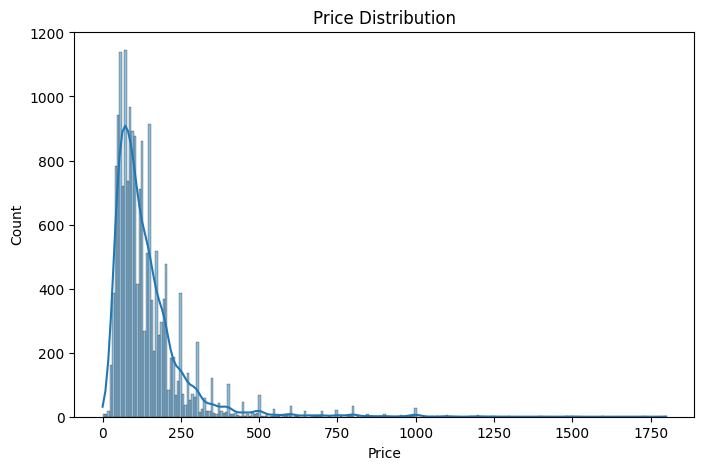

In [67]:
reg_df = reg_df[reg_df['price'] < 2000]

plt.figure(figsize=(8,5))
sns.histplot(reg_df['price'], bins='auto', kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [68]:
# подготавливаем данные

from sklearn.feature_extraction.text import TfidfVectorizer

X_clf = clf_df['Review'].values
y_clf = clf_df['Liked'].values

vectorizer = TfidfVectorizer(max_features=3000)
X_clf = vectorizer.fit_transform(X_clf)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)


In [69]:
# подготовка данных для регрессии

target_column = "price"

num_cols = reg_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove(target_column)

X_reg = reg_df[num_cols].fillna(reg_df[num_cols].median())
y_reg = reg_df[target_column]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [70]:
# функции оценки качества

def eval_clf(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }

def eval_reg(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


In [71]:
# обучение и оценка базовой модели

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_clf, y_train_clf)

y_pred_clf = knn_clf.predict(X_test_clf)

print(eval_clf(y_test_clf, y_pred_clf))


{'accuracy': 0.73, 'precision': 0.7309253246753247, 'recall': 0.7279647435897436, 'f1_macro': 0.7282608695652174}


In [72]:
# обучение и оценка

scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_reg_scaled, y_train_reg)

y_pred_reg = knn_reg.predict(X_test_reg_scaled)

print(eval_reg(y_test_reg, y_pred_reg))


{'MAE': 70.34297896532121, 'MSE': 13036.915054007957, 'RMSE': np.float64(114.17931097185671), 'R2': 0.08991375515768096}


In [73]:
# подбор гиперпараметра классификация

params = {"n_neighbors": [3, 5, 7, 9]}

gs_clf = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=3,
    scoring="f1_macro"
)

gs_clf.fit(X_train_clf, y_train_clf)

print(gs_clf.best_params_)


{'n_neighbors': 7}


In [74]:
# подбор гиперпараметра регрессия

params = {"n_neighbors": [3, 5, 7, 9]}

gs_reg = GridSearchCV(
    KNeighborsRegressor(),
    params,
    cv=3,
    scoring="r2"
)

gs_reg.fit(X_train_reg_scaled, y_train_reg)

print(gs_reg.best_params_)


{'n_neighbors': 9}


In [75]:
# моя раелизация

class MyKNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        preds = []
        for x in X:
            dists = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            idx = np.argsort(dists)[:self.k]
            vals, counts = np.unique(self.y_train[idx], return_counts=True)
            preds.append(vals[np.argmax(counts)])
        return np.array(preds)


In [76]:
# тест моей реализации

clf_manual = MyKNN(k=5)
clf_manual.fit(X_train_clf.toarray(), y_train_clf)

y_pred_manual = clf_manual.predict(X_test_clf.toarray())
print(eval_clf(y_test_clf, y_pred_manual))


{'accuracy': 0.73, 'precision': 0.7309253246753247, 'recall': 0.7279647435897436, 'f1_macro': 0.7282608695652174}


In [77]:
# сравнение

import pandas as pd

df_compare = pd.DataFrame([
    ["KNN baseline", eval_clf(y_test_clf, y_pred_clf)["f1_macro"]],
    ["KNN best", eval_clf(y_test_clf, gs_clf.predict(X_test_clf))["f1_macro"]],
    ["KNN manual", eval_clf(y_test_clf, y_pred_manual)["f1_macro"]],
], columns=["Модель", "F1"])
df_compare


,Модель,F1
0,KNN baseline,0.728261
1,KNN best,0.737877
2,KNN manual,0.728261
